### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.

Напомним, что на лекциях и семинарах мы разбирали некоторые подходы к оптимизации функционалов по параметрам. В частности, был рассмотрен градиентный спуск и различные подходы к его реализации — стохастический, метод импульса и другие. В качестве модели у нас будет выступать линейная регрессия.

В этом домашнем задании вам предстоит реализовать 4 различных вариации градиентного спуска, написать свою реализацию линейной регресии, сравнить методы градиентного спуска между собой на реальных данных и разобраться как подбирать гиперпараметры для этих методов.

## Задание 1. Реализация градиентного спуска (3.5 балла)

В этом задании вам предстоит написать собственные реализации различных подходов к градиентному спуску с опорой на подготовленные шаблоны в файле  `utils.py`:

**Задание 1.1. (0.5 балла)** Полный градиентный спуск **GradientDescent**:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

**Задание 1.2. (1 балл)** Стохастический градиентный спуск **StochasticDescent**:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} q_{i_{k}}(w_{k}).
$$ 

$\nabla_{w} q_{i_{k}}(w_{k}) \,$ - это оценка градиента по батчу объектов, выбранных случайно.

**Задание 1.3. (1 балл)** Метод Momentum **MomentumDescent**:

$$
    h_0 = 0, \\
    h_{k + 1} = \alpha h_{k} + \eta_k \nabla_{w} Q(w_{k}), \\
    w_{k + 1} = w_{k} - h_{k + 1}.
$$

**Задание 1.4. (1 балл)** Метод Adaptive gradient algorithm **Adagrad**:

$$
    G_0 = 0, \\
    G_{k + 1} = G_{k} + \left(\nabla_{w} Q(w_{k})\right) ^ 2, \\
    w_{k + 1} = w_{k} - \dfrac{\eta_k}{\sqrt{\varepsilon + G_{k + 1}}} \nabla_{w} Q(w_{k}).
$$


Во всех вышеназванных методах мы будем использовать следующую формулу для длины шага:

$$
    \eta_{k} = \lambda \left(\dfrac{s_0}{s_0 + k}\right)^p
$$
На практике достаточно настроить параметр $\lambda$, а остальным выставить параметры по умолчанию: $s_0 = 1, \, p = 0.5.$

Мы будем использовать функцию потерь MSE:

$$
    Q(w) = \dfrac{1}{\ell} \sum\limits_{i=1}^{\ell} (a_w(x_i) - y_i)^2
$$

Все вычисления должны быть векторизованы.

## Задание 2. Реализация линейной регресии (1.5 балла)

В этом задании вам предстоит написать свою реализацию линейной регресии, обучаемой с использованием градиентного спуска, с опорой на подготовленные шаблоны в файле `utils.py` - **LinearRegression**.

Необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы.
* Циклы средствами python допускаются только для итераций градиентного спуска.
* В качестве критерия останова необходимо использовать (одновременно):
    * Квадрат евклидовой нормы разности весов на двух соседних итерациях меньше `tolerance`.
    * Достижение максимального числа итераций `max_iter`.
* Чтобы проследить за сходимостью оптимизационного процесса будем использовать `loss_history`, в нём будем хранить значения функции потерь до каждого шага, начиная с нулевого (до первого шага по антиградиенту).
* Инициализировать веса нужно нулевым вектором или из нормального $\mathcal{N}(0, 1)$ распределения (тогда нужно зафиксировать seed).

## Задание 3. Проверка кода (0 баллов)

In [139]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
%autoreload 2

import numpy as np

from utils import (
    Adagrad,
    GradientDescent,
    MomentumDescent,
    StochasticDescent,
)
from utils import LinearRegression

In [141]:
from haversine import haversine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
from sklearn.metrics import mean_squared_error as mse
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
import os 
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator
import random

In [142]:
num_objects = 100
dimension = 5

X = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)

lambda_ = 1e-2
w0 = np.zeros(dimension)

max_iter = 10
tolerance = 0

In [143]:
s0_default: float = 1
p_default: float = 0.5

batch_size_default: int = 1

alpha_default: float = 0.1
eps_default: float = 1e-8

mu_default = 1e-2

tolerance_default: float = 1e-3
max_iter_default: int = 1000

In [144]:
class BaseDescent:
    """
    A base class and examples for all functions
    """

    def __init__(self):
        self.w = None

    def step(self, X: np.ndarray, y: np.ndarray, iteration: int) -> np.ndarray:
        """
        Descent step
        :param iteration: iteration number
        :param X: objects' features
        :param y: objects' targets
        :return: difference between weights
        """
        return self.update_weights(self.calc_gradient(X, y), iteration)

    def update_weights(self, gradient: np.ndarray, iteration: int) -> np.ndarray:
        """
        Example for update_weights function
        :param iteration: iteration number
        :param gradient: gradient
        :return: weight difference: np.ndarray
        """
        pass


    def calc_gradient(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Example for calc_gradient function
        :param X: objects' features
        :param y: objects' targets
        :return: gradient: np.ndarray
        """
        pass

In [145]:
class GradientDescent(BaseDescent):
    """
    Full gradient descent class
    """

    def __init__(self, w0: np.ndarray, lambda_: float, s0: float = s0_default, p: float = p_default):
        """
        :param w0: weight initialization
        :param lambda_: learning rate parameter (float)
        :param s0: learning rate parameter (float)
        :param p: learning rate parameter (float)
        """
        super().__init__()
        self.eta = lambda k: lambda_ * (s0 / (s0 + k)) ** p
        self.w = np.copy(w0)

    def update_weights(self, gradient: np.ndarray, iteration: int) -> np.ndarray:
        """
        Changing weights with respect to gradient
        :param iteration: iteration number
        :param gradient: gradient
        :return: weight difference: np.ndarray
        """
        # TODO: implement updating weights function
        for i in range(iteration):
            step = self.eta(iteration) * calc_gradient(X, y)
            self.w -= step
        return self.w

    def calc_gradient(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Getting objects, calculating gradient at point w
        :param X: objects' features
        :param y: objects' targets
        :return: gradient: np.ndarray
        """
        # TODO: implement calculating gradient function
        return (X@self.w-y)@X /(len(y))

In [146]:
# GradientDescent

descent = GradientDescent(lambda_ = lambda_, w0 = w0)

gradient = descent.calc_gradient(X, y)

assert gradient.shape[0] == dimension, 'Gradient failed'

diff = descent.step(X, y, 0)

assert diff.shape[0] == dimension, 'Weights failed'

In [147]:
gradient, diff

(array([-0.26640824, -0.28437732, -0.29128247, -0.27773697, -0.29172162]),
 array([0., 0., 0., 0., 0.]))

In [148]:
class StochasticDescent(BaseDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, w0: np.ndarray, lambda_: float, s0: float = s0_default, p: float = p_default,
                 batch_size: int = batch_size_default):
        """
        :param w0: weight initialization
        :param lambda_: learning rate parameter (float)
        :param s0: learning rate parameter (float)
        :param p: learning rate parameter (float)
        :param batch_size: batch size (int)
        """
        super().__init__()
        self.eta = lambda k: lambda_ * (s0 / (s0 + k)) ** p
        self.batch_size = batch_size
        self.loss_history = []
        self.w = np.copy(w0)

    def update_weights(self, gradient: np.ndarray, iteration: int) -> np.ndarray:
        """
        Changing weights with respect to gradient
        :param iteration: iteration number
        :param gradient: gradient estimate
        :return: weight difference: np.ndarray
        """
        # TODO: implement updating weights function
        for i in range(iteration):
            random_indexes = random.sample([i for i in range(len(y))], self.batch_size)
            step = self.eta(iteraton)*self.calc_gradient(X[random_indexes], y[random_indexes]) 
            self.w -= step
            self.loss_history.append(mse(X@self.w, y))
        return self.w

    def calc_gradient(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Getting objects, calculating gradient at point w
        :param X: objects' features
        :param y: objects' targets
        :return: gradient: np.ndarray
        """
        # TODO: implement calculating gradient function
        return (X@self.w-y)@X /(len(y))

In [149]:
# StochasticDescent

descent = StochasticDescent(lambda_ = lambda_, w0 = w0)

gradient = descent.calc_gradient(X, y)

assert gradient.shape[0] == dimension, 'Gradient failed'

diff = descent.step(X, y, 0)

assert diff.shape[0] == dimension, 'Weights failed'

In [150]:
gradient, diff

(array([-0.26640824, -0.28437732, -0.29128247, -0.27773697, -0.29172162]),
 array([0., 0., 0., 0., 0.]))

In [151]:
class MomentumDescent(BaseDescent):
    """
    Momentum gradient descent class
    """

    def __init__(self, w0: np.ndarray, lambda_: float, alpha: float = alpha_default, s0: float = s0_default,
                 p: float = p_default):
        """
        :param w0: weight initialization
        :param lambda_: learning rate parameter (float)
        :param alpha: momentum coefficient
        :param s0: learning rate parameter (float)
        :param p: learning rate parameter (float)
        """
        super().__init__()
        self.eta = lambda k: lambda_ * (s0 / (s0 + k)) ** p
        self.alpha = alpha
        self.w = np.copy(w0)
        self.h = 0

    def update_weights(self, gradient: np.ndarray, iteration: int) -> np.ndarray:
        """
        Changing weights with respect to gradient
        :param iteration: iteration number
        :param gradient: gradient estimate
        :return: weight difference: np.ndarray
        """
        for i in range(iteration):
            self.h = self.h*self.alpha + self.eta(iteraton)*self.calc_gradient(X, y)
            self.w -= self.h
        return self.w

    def calc_gradient(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Getting objects, calculating gradient at point w
        :param X: objects' features
        :param y: objects' targets
        :return: gradient: np.ndarray
        """
        # TODO: implement calculating gradient function
        return (X@self.w-y)@X /(len(y))

In [152]:
# MomentumDescent

descent = MomentumDescent(lambda_ = lambda_, w0 = w0)

gradient = descent.calc_gradient(X, y)

assert gradient.shape[0] == dimension, 'Gradient failed'

diff = descent.step(X, y, 0)

assert diff.shape[0] == dimension, 'Weights failed'

In [153]:
gradient, diff

(array([-0.26640824, -0.28437732, -0.29128247, -0.27773697, -0.29172162]),
 array([0., 0., 0., 0., 0.]))

In [154]:
class Adagrad(BaseDescent):
    """
    Adaptive gradient algorithm class
    """

    def __init__(self, w0: np.ndarray, lambda_: float, eps: float = eps_default, s0: float = s0_default,
                 p: float = p_default):
        """
        :param w0: weight initialization
        :param lambda_: learning rate parameter (float)
        :param eps: smoothing term (float)
        :param s0: learning rate parameter (float)
        :param p: learning rate parameter (float)
        """
        super().__init__()
        self.eta = lambda k: lambda_ * (s0 / (s0 + k)) ** p
        self.eps = eps
        self.w = np.copy(w0)
        self.g = 0

    def update_weights(self, gradient: np.ndarray, iteration: int) -> np.ndarray:
        """
        Changing weights with respect to gradient
        :param iteration: iteration number
        :param gradient: gradient estimate
        :return: weight difference: np.ndarray
        """
        # TODO: implement updating weights function
        self.g = np.zeros(np.shape(y))
        for i in range(iteration):
            random_indexes = random.sample([i for i in range(len(y))], self.batch_size)
            self.g += calc_gradient(X[random_indexes], y[random_indexes]) ** 2
            self.w -= self.eta(iteration) / ((self.g + self.eps)**0.5) * calc_gradient(X[random_indexes], y[random_indexes])
        return self.w      

    def calc_gradient(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Getting objects, calculating gradient at point w
        :param X: objects' features
        :param y: objects' targets
        :return: gradient: np.ndarray
        """
        # TODO: implement calculating gradient function
        return (X@self.w-y)@X /(len(y))

In [155]:
# Adagrad

descent = Adagrad(lambda_ = lambda_, w0 = w0)

gradient = descent.calc_gradient(X, y)

assert gradient.shape[0] == dimension, 'Gradient failed'

diff = descent.step(X, y, 0)

assert diff.shape[0] == dimension, 'Weights failed'

In [156]:
gradient, diff

(array([-0.26640824, -0.28437732, -0.29128247, -0.27773697, -0.29172162]),
 array([0., 0., 0., 0., 0.]))

In [157]:
np.zeros(shape=X.shape[1])

array([0., 0., 0., 0., 0.])

In [158]:
class LinearReg(BaseEstimator):
    def __init__(self,
                 gd_type='stochastic', 
                 tolerance=tolerance_default,
                 max_iter=max_iter_default,
                 weight=None,
                 eta=1e-2,
                 batch_size: int = batch_size_default):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w = weight
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        self.batch_size = batch_size
        self.real_iter = 0

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
#         X = sm.add_constant(X)
        
        if self.w==None:
            self.w = np.zeros(shape=X.shape[1])

        self.loss_history = []

        if self.gd_type == 'full':
            
            for i in range(self.max_iter):
                self.real_iter += 1
                step = self.eta * self.calc_gradient(X,y)
                self.w -= step
                self.loss_history.append(self.calc_loss(X, y))
                if np.linalg.norm(step) < self.tolerance: 
                    break
        
        else:
            
            for i in range(self.max_iter):
                self.real_iter += 1
                random_indexes = np.random.randint(X.shape[0], size=self.batch_size)
                step=self.eta*self.calc_gradient(X[random_indexes], y[random_indexes])  
                self.w = self.w-step
                self.loss_history.append(self.calc_loss(X, y))
                if np.linalg.norm(step) < self.tolerance:
                    break

        return self
    
    def predict(self, X):
#         X = sm.add_constant(X)
        if self.w is None:
            raise Exception('Not trained yet')
        
        return X.dot(self.w)
    
    def calc_gradient(self, X, y):
        """
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
#         print(f'size of weight {self.w.shape}')
#         print(f'size of X = {X.shape}', f'size of y_pred = {(X@self.w - y).shape}', f'size of y {y.shape}')

#         return (X.T @ (X@self.w - y)) / np.size(y)
        return (X.T.dot(X.dot(self.w) - y))/ X.shape[0]

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """
        return mse(X@self.w, y)

In [159]:
import seaborn as sns

## Задание 4. Работа с данными (1 балл)

In [160]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [161]:
# YOUR CODE:
df = pd.read_csv('autos.csv')
df["log_price"] = np.log1p(df["price"])
y = df['log_price']
df = df.drop(columns = ['dateCreated', 'lastSeen','postalCode','price', 'log_price'])

In [162]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.4, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [163]:
numeric = df.select_dtypes([np.number]).columns
categorical = list(df.dtypes[df.dtypes == "object"].index)

In [164]:
column_trainsform = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('SS', StandardScaler(), numeric)
])

X_train_tf = column_trainsform.fit_transform(X_train)
X_test_tf = column_trainsform.fit_transform(X_test)
X_valid_tf = column_trainsform.fit_transform(X_valid)

In [165]:
import scipy.sparse

In [166]:
tt = pd.DataFrame.sparse.from_spmatrix(X_train_tf)
tt.head(1)

,0,1,2,3,4,5,6,7,8,9,...,301,302,303,304,305,306,307,308,309,310
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,-0.873632,0.658371,-0.075759,0.227382


In [167]:
idx = np.random.randint(X_train_tf.shape[0],size=10).tolist()
tt.iloc[idx].head(1)

,0,1,2,3,4,5,6,7,8,9,...,301,302,303,304,305,306,307,308,309,310
34636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,-0.391032,-1.855012,1.643193,-0.934572


In [168]:
X_train_tf, y_train.shape

(<148723x311 sparse matrix of type '<class 'numpy.float64'>'
 	with 1487230 stored elements in Compressed Sparse Row format>,
 (148723,))

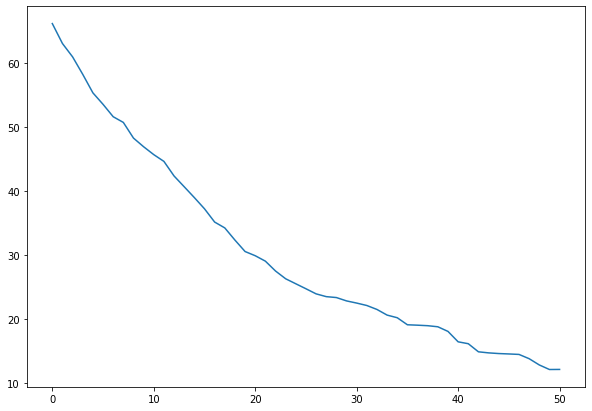

In [174]:
gd = LinearReg(tolerance=0.01, batch_size=1).fit(X_valid_tf, y_valid.reset_index(drop=True))

f, ax = plt.subplots(figsize=(10, 7))
ax = sns.lineplot(x=np.arange(gd.real_iter), y=gd.loss_history)

In [175]:
idx = np.random.randint(X_train_tf.shape[0],size=10)
idx

array([27290, 96110,  6117, 34848,  6633, 30175, 30808,  1372, 95597,
       48032])

In [176]:
X_train_tf[idx]

<10x311 sparse matrix of type '<class 'numpy.float64'>'
	with 100 stored elements in Compressed Sparse Row format>

## Задание 5. Сравнение методов градиентного спуска (2 балла)

В этом задании вам предстоит сравнить методы градиентного спуска на подготовленных вами данных из предыдущего задания.

* **Задание 5.1. (1.5 балла)** Подберите по валидационной выборке наилучшую длину $\lambda$ шага для каждого метода. Для этого можно сделать перебор по логарифмической сетке, так как нас интересует скорее порядок величины, нежели её точное значение. Сравните качество методов по метрикам MSE и R^2 на обучающей и тестовой выборках, сравните количество итераций до сходимости. Все параметры кроме $\lambda$ стоит выставить равным значениям по умолчанию.

* **Задание 5.2. (0.5 балла)** Постройте график зависимости значения функции ошибки от номера итерации (все методы на одном графике).

Посмотрите на получившиеся результаты. Сравните методы между собой.

In [180]:
y_train.values

array([6.2166061 , 8.00336306, 8.64839688, ..., 7.09090982, 9.25922577,
       8.78630388])

In [186]:
columns = ['eta', 'test_mse', 'test_r2', 'train_mse', 'train_r2']
full_df = pd.DataFrame(columns=columns)
sg_df = pd.DataFrame(columns=columns)


for i in np.logspace(-2, 0, 7):
    print(i)
    #full gd
    gd_full=LinearReg(gd_type='full', tolerance=0.01).fit(X_train_tf, y_train.reset_index(drop=True))

    y_train_pred = gd_full.predict(X_train_tf)
    y_pred = gd_full.predict(X_test_tf)
    
    test_mse = mse(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    train_mse = mse(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    temp_test_df = pd.DataFrame({'eta':[0.1*(10**(-i))],
                            'test_mse': [test_mse],
                       'test_r2': [-test_r2],
                       'train_mse': [train_mse],
                       'train_r2': [-train_r2]})
    
    full_df = pd.concat([full_df, temp_test_df], ignore_index=True)
    
    sg_full=LinearReg(tolerance=0.01, batch_size=1).fit(X_train_tf, y_train.reset_index(drop=True))
    
    y_train_pred = sg_full.predict(X_train_tf)
    y_pred = sg_full.predict(X_test_tf)
    
    test_mse = mse(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    train_mse = mse(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    temp_test_df = pd.DataFrame({'eta':[0.1*(10**(-i))],
                            'test_mse': [test_mse],
                       'test_r2': [-test_r2],
                       'train_mse': [train_mse],
                       'train_r2': [-train_r2]})
    
    sg_df = pd.concat([sg_df, temp_test_df], ignore_index=True)
    
    
full_df

0.01


ValueError: dimension mismatch

In [ ]:
sg_df

## Задание 6. Сходимость стохастического градиентного спуска в зависимости от размера батча (1 балл)

В этом задании вам предстоит исследовать влияние размера батча на работу стохастического градиентного спуска. 

* Сделайте по несколько запусков (например, k) стохастического градиентного спуска на обучающей выборке для каждого размера батча из списка. Замерьте время и количество итераций до сходимости. Посчитайте среднее и дисперсию этих значений для каждого размера батча.
* Постройте график зависимости количества шагов до сходимости от размера батча.
* Постройте график зависимости времени до сходимости от размера батча.

Посмотрите на получившиеся результаты. Какие выводы можно сделать про подбор размера батча для стохастического градиентного спуска?

In [ ]:
batch_sizes = np.arange(5, 500, 50)

columns = ['batch_size', 'iter_count', 'test_mse', 'test_r2', 'train_mse', 'train_r2']
sg_df = pd.DataFrame(columns=columns)


for batch_size in batch_sizes:
    print(batch_size)
    for i in range(5):

        sg_full=LinearReg(eta=1e-3, batch_size=batch_size).fit(X_train_scaled, X_train['log_trip_duration'].to_numpy())

        y_train_pred = sg_full.predict(X_train_scaled)
        y_pred = sg_full.predict(X_test_scaled)

        test_mse = mse(X_test['log_trip_duration'], y_pred)
        test_r2 = r2_score(X_test['log_trip_duration'], y_pred)
        train_mse = mse(X_train['log_trip_duration'], y_train_pred)
        train_r2 = r2_score(X_train['log_trip_duration'], y_train_pred)

        temp_test_df = pd.DataFrame({'batch_size':[batch_size],
                                     'iter_count': [sg_full.real_iter],
                                     'test_mse': [test_mse],
                                     'test_r2': [-test_r2],
                                     'train_mse': [train_mse],
                                     'train_r2': [-train_r2]})

        sg_df = pd.concat([sg_df, temp_test_df], ignore_index=True)
    
    
sg_df